In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.operators import total_mass, total_momentum, total_energy_k, total_L2_norm
from operators.operators import solve_poisson_equation, psi_ln_sw, solve_poisson_equation, fft_, J_matrix_inv
from operators.operators import integral_I1, integral_I2, integral_I0, linear_2_two_stream_SW
from operators.closure import closure_momentum, closure_energy

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib.pylab as pl
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Langmuir Wave SW 

In [4]:
# set up configuration parameters
# number of Fourier spectral terms in x
Nx = 50
Nx_total = 2 * Nx + 1
# number of Hermite spectral terms in v
Nv = 11
# Velocity scaling of electron and ion
alpha_e = 0.1
alpha_i = np.sqrt(1 / 1836)
# perturbation magnitude
epsilon = 0.01
# x grid is from 0 to L
L = 2 * np.pi
# final time
T = 100
# time stepping
dt = 0.1
# time vector
t_vec = np.linspace(0, T, int(T / dt) + 1)
# velocity scaling
u_e = 1
u_i = 1
# mass normalized
m_e = 1
m_i = 1836
# charge normalized
q_e = -1
q_i = 1
# closure
closure = "momentum"

In [5]:
# inverse J
J_inv = J_matrix_inv(Nx=Nx, L=L)

In [6]:
# velocity grid for plotting purposes
v = np.linspace(0.5, 1.5, int(1e3))
# spatial grid 
x_project = np.linspace(0, L, int(1e5))
x = np.linspace(0, L, Nx_total)

## read in simulation results

In [7]:
sol_midpoint_u = np.load("../data/SW/langmuir/sol_midpoint_u_" + str(Nv) + "_" + str(closure) + "_closure.npy")
sol_midpoint_t = np.load("../data/SW/langmuir/sol_midpoint_t_" + str(Nv) + "_" + str(closure) + "_closure.npy")
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(2229, 1)
(1,)


In [8]:
# initialize the electric potential
E_midpoint = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")

In [9]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")
state_i_midpoint = np.zeros((Nv, Nx_total, len(sol_midpoint_t)), dtype="complex128")

closure_e = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")
closure_i = np.zeros((Nx_total, len(sol_midpoint_t)), dtype="complex128")

for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj * Nx_total: (jj + 1) * Nx_total, ii]
        state_i_midpoint[jj, :, ii] = sol_midpoint_u[Nv * Nx_total + jj * Nx_total: Nv * Nx_total + (jj + 1) * Nx_total, ii]

    E_midpoint[:, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii],
                                               state_i=state_i_midpoint[:, :, ii],
                                               alpha_e=alpha_e, alpha_i=alpha_i, Nx=Nx, L=L, Nv=Nv)
    # energy closure
    if closure == "energy":
        closure_e = closure_energy(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, u_s=u_e, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_e, m_s=m_e, Nx_total=Nx_total, Nx=Nx)
        closure_i = closure_energy(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, u_s=u_i, Nv=Nv, E=E_midpoint[:, ii], J_inv=J_inv, q_s=q_i, m_s=m_i, Nx_total=Nx_total, Nx=Nx)

    # momentum closure
    elif closure == "momentum":
        # momentum closure
        closure_e = closure_momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, u_s=u_e, Nv=Nv)
        closure_i = closure_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, u_s=u_i, Nv=Nv)

    # total mass closure
    elif closure == "mass":
        #  mass closure
        closure_e = closure_mass(state=state_e, E=E, Nx=Nx)
        closure_i = closure_mass(state=state_i,  E=E, Nx=Nx)

    # truncation
    elif closure == "truncation":
        #  mass closure
        closure_e = np.zeros(Nx_total)
        closure_i = np.zeros(Nx_total)

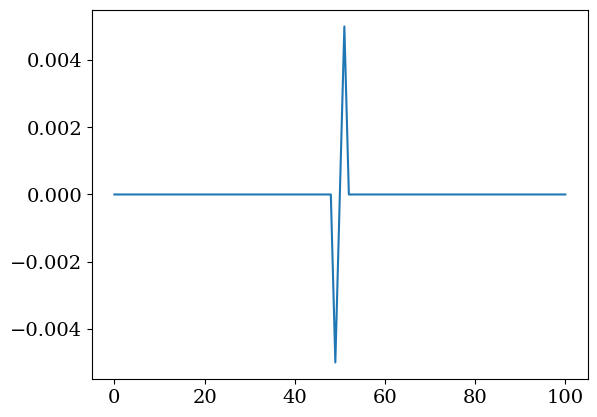

In [10]:
_  = plt.plot(E_midpoint[:, :].imag)

In [11]:
E_field = np.zeros(np.shape(E_midpoint))
for ii in range(len(sol_midpoint_t)):
    E_field[:, ii] = fft_(E_midpoint[:, ii], Nx, x, L)

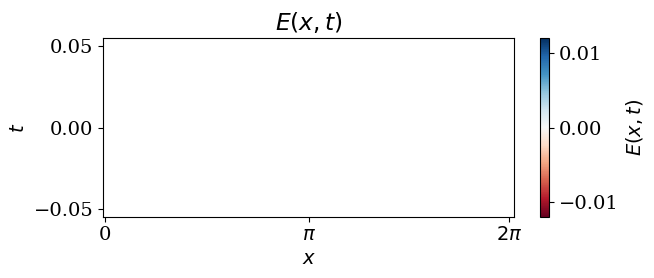

In [12]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.pcolormesh(x, sol_midpoint_t, E_field.T, cmap="RdBu", vmin=-0.012, vmax=0.012)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/SW/langmuir/electric_field_SW_" + str(closure) + "_" + str(Nv) + ".png", dpi=600)

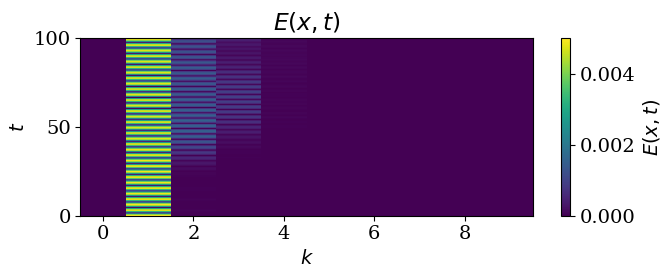

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.pcolormesh(np.arange(10), sol_midpoint_t, np.abs(E_midpoint[Nx:Nx+10, :]).T, cmap="viridis", vmin=0, vmax=0.005)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$k$")
# _ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
# _ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("../figs/SW/langmuir/electric_field_SW_" + str(closure) + "_" + str(Nv) + ".png", dpi=600)

In [25]:
E1_midpoint = np.zeros(len(sol_midpoint_t))
E2_midpoint = np.zeros(len(sol_midpoint_t))
E3_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(E_midpoint[Nx+1, ii])
    E2_midpoint[ii] = np.abs(E_midpoint[Nx+2, ii])
    E3_midpoint[ii] = np.abs(E_midpoint[Nx+3, ii])

In [26]:
np.save("../data/SW/langmuir/E1_midpoint_" + str(closure) + "_" + str(Nv) + ".npy", E1_midpoint)
np.save("../data/SW/langmuir/E2_midpoint_" + str(closure) + "_" + str(Nv) + ".npy", E2_midpoint)
np.save("../data/SW/langmuir/E3_midpoint_" + str(closure) + "_" + str(Nv) + ".npy", E3_midpoint)
np.save("../data/SW/langmuir/E_field_" + str(closure) + "_" + str(Nv) + ".npy", E_field)

In [21]:
E1_midpoint_truncation_11 = np.load("../data/SW/langmuir/E1_midpoint_truncation_11.npy")
E1_midpoint_momentum_11 = np.load("../data/SW/langmuir/E1_midpoint_momentum_11.npy")

E2_midpoint_truncation_11 = np.load("../data/SW/langmuir/E2_midpoint_truncation_11.npy")
E2_midpoint_momentum_11 = np.load("../data/SW/langmuir/E2_midpoint_momentum_11.npy")

E_field_truncation_11 = np.load("../data/SW/langmuir/E_field_truncation_11.npy")
E_field_momentum_11 = np.load("../data/SW/langmuir/E_field_momentum_11.npy")

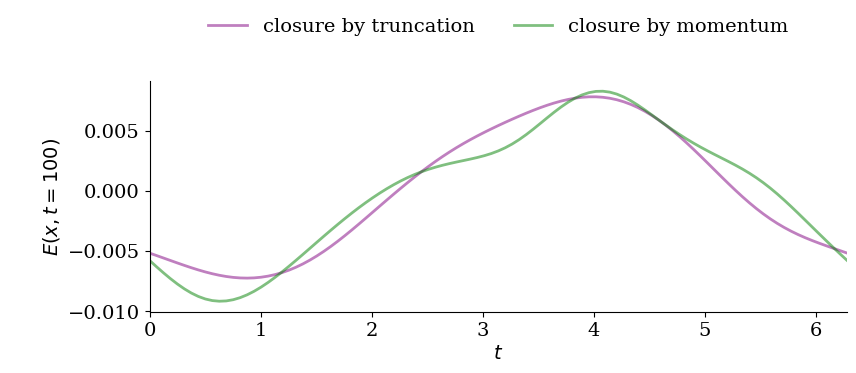

In [22]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(x, E_field_truncation_11[:, -1], "-", c="purple", alpha=0.5, linewidth=2, label="closure by truncation") 
ax.plot(x, E_field_momentum_11[:, -1], "-", c="green", alpha=0.5, linewidth=2, label="closure by momentum") 
#ax.plot(x, E_field_energy_11[:, -1], "-", c="green", alpha=0.5, linewidth=2, label="closure by energy") 
#ax.plot(x, E_field_mass_11[:, -1], "-", c="green", alpha=0.5, linewidth=2, label="closure by mass") 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$E(x, t=100)$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, x[-1])
legend = ax.legend(ncols=3, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.35))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/langmuir/damping_rate_electric_field.png", bbox_inches='tight', dpi=600)

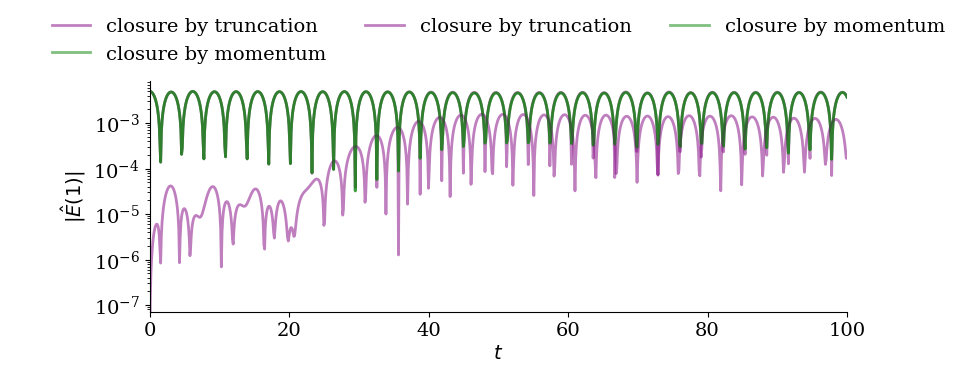

In [23]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(sol_midpoint_t, E1_midpoint_truncation_11, "-", c="purple", alpha=0.5, linewidth=2, label="closure by truncation") 
ax.plot(sol_midpoint_t, E1_midpoint_momentum_11, "-", c="green", alpha=0.5, linewidth=2, label="closure by momentum") 

ax.plot(sol_midpoint_t, E2_midpoint_truncation_11, "-", c="purple", alpha=0.5, linewidth=2, label="closure by truncation") 
ax.plot(sol_midpoint_t, E2_midpoint_momentum_11, "-", c="green", alpha=0.5, linewidth=2, label="closure by momentum") 
#ax.plot(sol_midpoint_t[:200], 2e-2*np.exp(sol_midpoint_t[:200]*0.17),  linewidth=2, c="red", label="linear theory $\gamma=0.17$")


ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, sol_midpoint_t[-1])
legend = ax.legend(ncols=3, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.35))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/langmuir/damping_rate_electric_field.png", bbox_inches='tight', dpi=600)

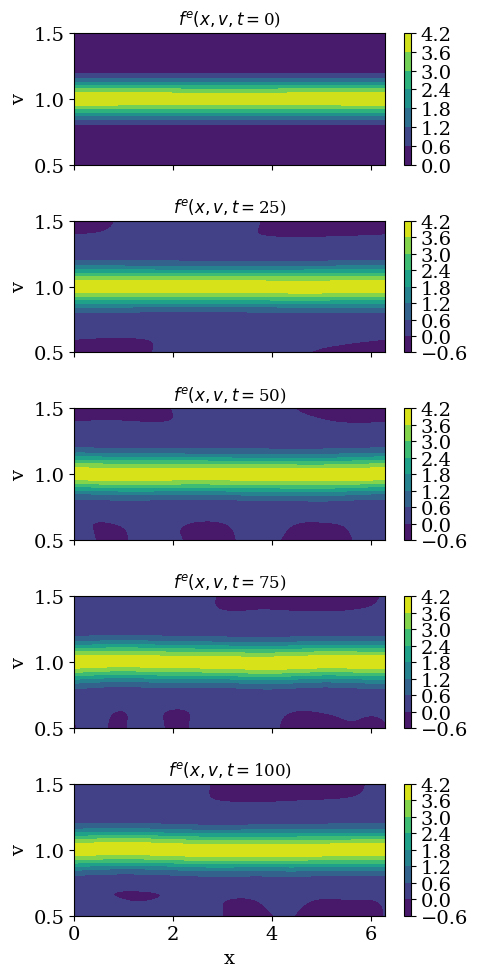

In [88]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)//4))):
    distribution = np.zeros((Nx_total, len(v)))
    for jj in range(Nv):
        distribution += np.outer(fft_(state_e_midpoint[jj, :, ii], Nx, x, L), psi_ln_sw(xi=(v-u_e)/alpha_e, v=v, u_s=u_e, alpha_s=alpha_e, n=jj)).real
           
    #levels = np.append(-0.1, np.linspace(0, 0.4, 15))
    pos = ax[tt].contourf(x, v, distribution.T)
    #ax[tt].set_xticks([0, 5*np.pi, 10*np.pi, 15*np.pi, 20*np.pi])
    #ax[tt].set_xticklabels([r"0", r"$5\pi$", r"$10\pi$", r"$15\pi$", r"$20\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    #cbar.ax.set_yticks([0, 0.2, 0.4])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")", fontsize=12)
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/weak_landau/weak_landau_evolution_SW.png", dpi=600)

# Conservation Laws

### mass conservation 

In [89]:
mass_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv, Nx=Nx)\
                      + total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, Nx=Nx)

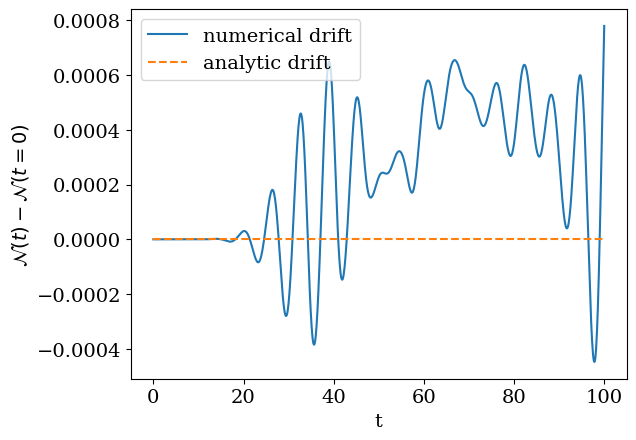

In [90]:
plt.plot(sol_midpoint_t, np.real(mass_midpoint - mass_midpoint[0]), label="numerical drift")
plt.plot(sol_midpoint_t, np.real(sol_midpoint_u[-2]).real, ls="--", label="analytic drift")
plt.ylabel(r"$\mathcal{N}(t)-\mathcal{N}(t=0)$")
plt.xlabel("t")
#plt.yscale("log")
plt.legend()

### momentum conservation

In [91]:
momentum_midpoint_e = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint_i = np.zeros(len(sol_midpoint_t), dtype="complex128")
momentum_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint_e[ii] = total_momentum(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv, m_s=m_e, u_s=u_e, Nx=Nx)
    momentum_midpoint_i[ii] =  total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, m_s=m_i, u_s=u_i, Nx=Nx)             
    
    momentum_midpoint[ii] = momentum_midpoint_e[ii]+ momentum_midpoint_i[ii]

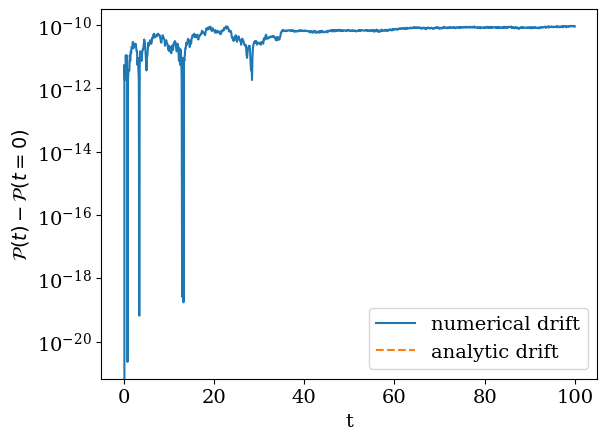

In [92]:
#plt.plot(sol_midpoint_t, np.abs(momentum_midpoint_i))
plt.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), label="numerical drift")
plt.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-4]), ls="--", label="analytic drift")
plt.ylabel(r"$\mathcal{P}(t)-\mathcal{P}(t=0)$")
plt.xlabel("t")
plt.yscale("log")
plt.legend()

### energy conservation

In [93]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")
energy_p_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv, m_s=m_e, u_s=u_e, Nx=Nx)\
                           +total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv, m_s=m_i, u_s=u_i, Nx=Nx)

    energy_p_midpoint[ii] = 0.5 * L * np.flip(E_midpoint[:, ii]).T @ E_midpoint[:, ii]

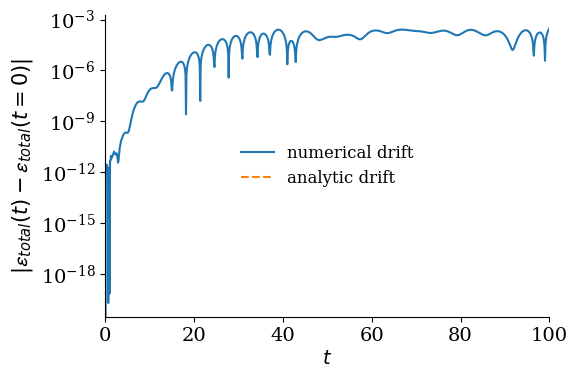

In [94]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), label="numerical drift")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-6]), ls="--", label="analytic drift")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

/opt/anaconda3/envs/rom/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/rom/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


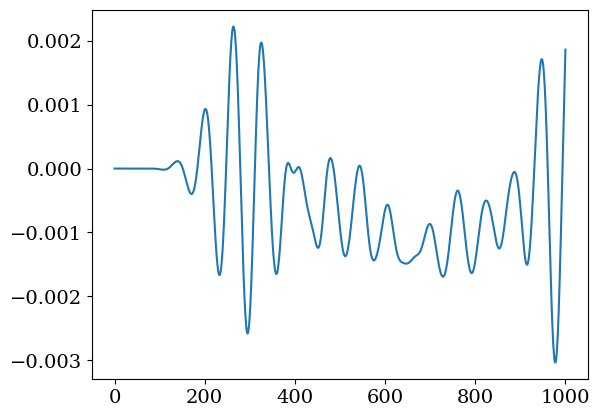

In [95]:
plt.plot(state_e_midpoint[-1, Nx,:])

In [96]:
L2_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    L2_midpoint[ii] = np.abs(total_L2_norm(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, L=L, Nv=Nv))\
                    + np.abs(total_L2_norm(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, L=L, Nv=Nv))

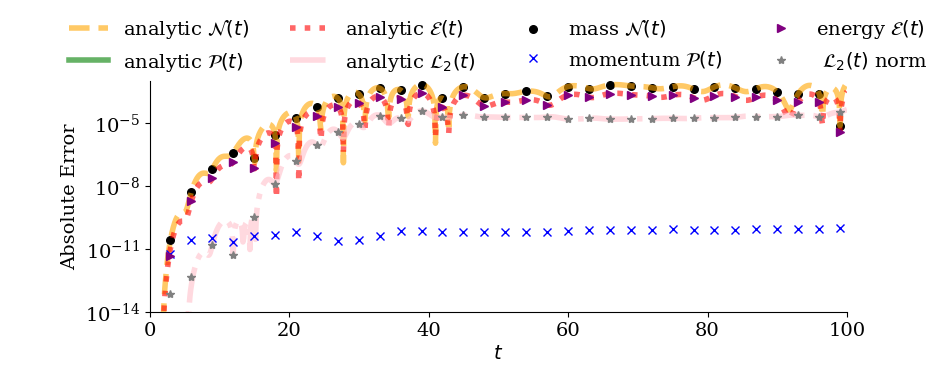

In [97]:
# plot overall conservation properties 
fig, ax = plt.subplots(ncols=1, figsize=(9, 3))
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), "--", c="orange", linewidth=4, alpha=0.6, label=r"analytic $\mathcal{N}(t)$ ")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-3]), "-", c="green", linewidth=4, alpha=0.6, label=r"analytic $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-5]), ":", c="red", linewidth=4, alpha=0.6, label=r"analytic $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-7]), "-.", c="pink", linewidth=4, alpha=0.6, label=r"analytic $\mathcal{L}_{2}(t)$")

ax.scatter(sol_midpoint_t[::30], np.abs(mass_midpoint-mass_midpoint[0])[::30], s=30, color="black", label=r"mass $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::30], np.abs(momentum_midpoint-momentum_midpoint[0])[::30], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::30], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::30], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t[::30], np.abs(L2_midpoint-L2_midpoint[0])[::30], "*", c="grey", label=r" $\mathcal{L}_{2}(t)$ norm")


ax.set_ylim(10**-14, 10**-3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
#ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xlabel("$t$")
ax.set_xlim(0, sol_midpoint_t[-1])
ax.set_yscale("log")
legend = ax.legend(ncols=4, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.35))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/langmuir/conservation_" + str(Nv) + "_bump_on_tail_SW_" + str(closure) + ".png", bbox_inches='tight', dpi=600)